# Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
from numpy import mean

# identification of ARIMA parameters
from statsmodels.tsa.stattools import acf, pacf # choose p and q

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = [16,8]

# custom functions
import sys
sys.path.append(r"C:\Users\User\Documents\projects\LHL_final_project_influenza_forecasting\src")
from evaluate_model import *
from ADF import *
from arima_model import *

# Function

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def arima_model(train, test, dataset, forecast_weeks, p, d, q):
    """
        Split data, the train, fit, evaluate and plot an ARIMA model for a specified number of weeks ahead to forecast
        
        Args:
            train (dataframe with DatetimeIndex): time series to train model on
            test (dataframe with DatetimeIndex): time series to validate model on
            dataset (string): 'Pre-COVID' or 'Full Dataset'
            forecast_weeks (int): number of weeks ahead to predict
            p (int): the time lag after which partial autocorrelation is no longer significant (aka no longer has an effect on current value). Choose using partial autocorrelation plot.
            d (int): the number of times differencing needs to be applied to achieve stationarity in the time series (aka pass the ADF test)
            q (int): the time lag after which autocorrelation is no longer significant. Choose using autocorrelation plot.
            
        Returns:
            MSE, RMSE, MAE, R2, plot of forecast

    """ 
    warnings.filterwarnings("ignore")
    
    # Instantiate model
    model = ARIMA(train, order=(p,d,q), freq='W-SAT')

    # Fit model
    fitted_model = model.fit()
    print(f'Fitted model summary: \n{fitted_model.summary()}')

    # # Forecast
    forecast = fitted_model.forecast(steps=forecast_weeks)
    for yhat in forecast:
        print(yhat)
    print(f'Forecast: \n{forecast}')

    preds_train = fitted_model.predict(start=train.index[0], end=train.index[-1])
    preds_test = fitted_model.predict(start=test.index[0], end=test.index[-1])

    # plot
    df = pd.concat([train, test], axis=0)
    plt.plot(df.index, df['Total Cases'].values, color='blue', label='Actual Cases')                    # actual cases, all datapoints
    plt.plot(train.index, preds_train, color='green', label='Predicted Cases - Training Set')           # predicted cases, training set
    plt.plot(test.index, preds_test, color='red', label='Predicted Cases - Test Set')                   # predicted cases, test set
    plt.title(dataset + ' Influenza Predictions'+' - '+str(forecast_weeks) +'-Week Forecast')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()
    
    # evaluate
    MSE_train = round(mean_squared_error(train, preds_train),2)
    MSE_test = round(mean_squared_error(test, preds_test),2)
    RMSE_train = round(mean_squared_error(train, preds_train, squared=False),2)
    RMSE_test = round(mean_squared_error(test, preds_test, squared=False),2)
    MAE_train = round(mean_absolute_error(train, preds_train),2)
    MAE_test = round(mean_absolute_error(test, preds_test),2)
    R2_train = r2_score(train, preds_train)
    R2_test = r2_score(test, preds_test)

    results = []

    results.append(MSE_train)
    results.append(MSE_test)
    results.append(RMSE_train)
    results.append(RMSE_test)
    results.append(MAE_train)
    results.append(MAE_test)
    results.append(R2_train)
    results.append(R2_test)
   
    results.insert(0, dataset)
    results.insert(1, forecast_weeks)

    results_matrix = pickle.load(open(r"..\data\results_matrix_ARIMA.pkl", "rb" ))
   
    results_matrix = pd.concat([results_matrix.T, pd.Series(results, index=results_matrix.columns)], axis=1).T

    pickle.dump(results_matrix, open(r"..\data\results_matrix_ARIMA.pkl", "wb" ))

    return results_matrix

In [3]:
results_matrix = pd.DataFrame(columns=['Dataset','Weeks-ahead Forecast','MSE_train','MSE_test','RMSE_train','RMSE_test','MAE_train','MAE_test','R2_train','R2_test'])

pickle.dump(results_matrix, open(r"..\data\results_matrix_ARIMA.pkl", "wb" ))

In [4]:
df_train = pickle.load(open(r"..\data\flu_cases\df_cases_pre_COVID_train.pkl", "rb" ))
df_test = pickle.load(open(r"..\data\flu_cases\df_cases_pre_COVID_test.pkl", "rb" ))

df_train = df_train.set_index('Week Ending')
df_test = df_test.set_index('Week Ending')

In [5]:
df_train.index[0]

Timestamp('2016-09-03 00:00:00')

In [6]:
df = pd.concat([df_train, df_test], axis=0)
df

,Total Cases
Week Ending,
2016-09-03,2.0
2016-09-10,18.0
2016-09-17,23.0
2016-09-24,44.0
2016-10-01,63.0
...,...
2020-02-01,4789.0
2020-02-08,4654.0
2020-02-15,3989.0


In [7]:
# test for stationarity - choose d
test_stationarity(df)

Results of Dickey-Fuller Test:
Test Statistic                  -4.279900
p-value                          0.000481
#Lags Used                       5.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64


In [8]:
d = 0 # time series is stationary, so don't need to apply differencing

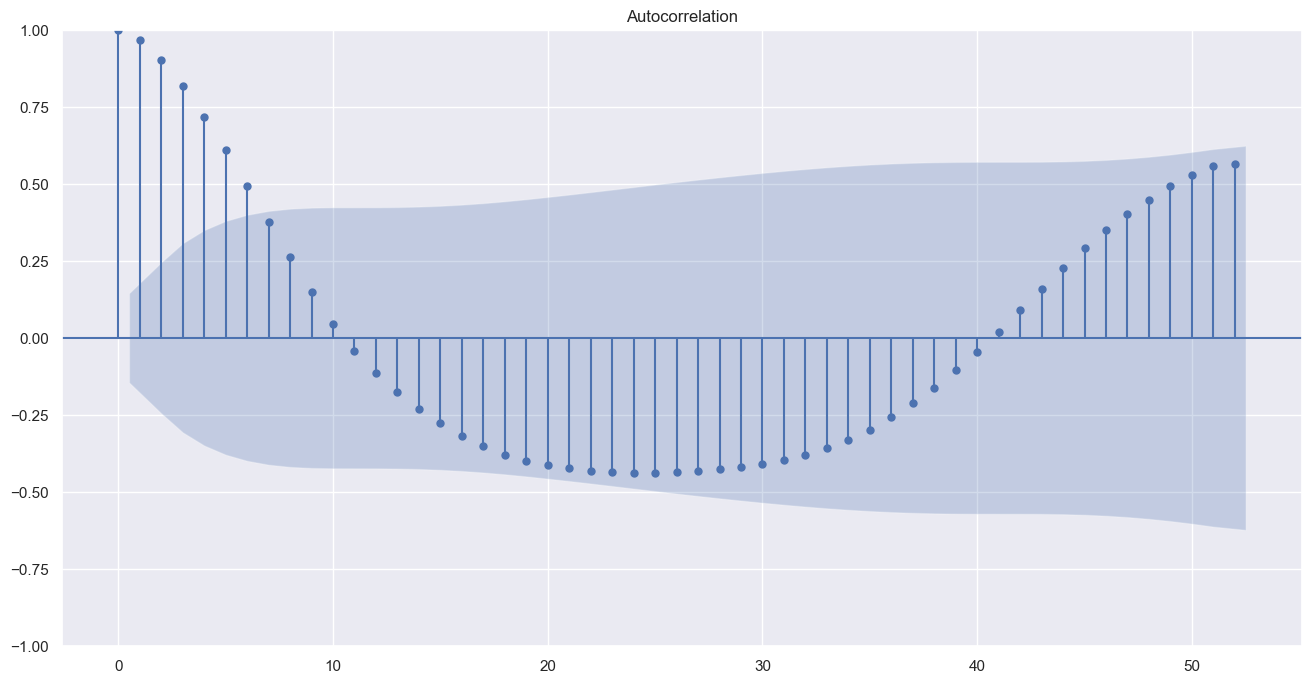

In [9]:
# plot acf and specify the number of lags - choose q
sm.graphics.tsa.plot_acf(df, lags=52)
plt.show()

In [10]:
q = 6

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


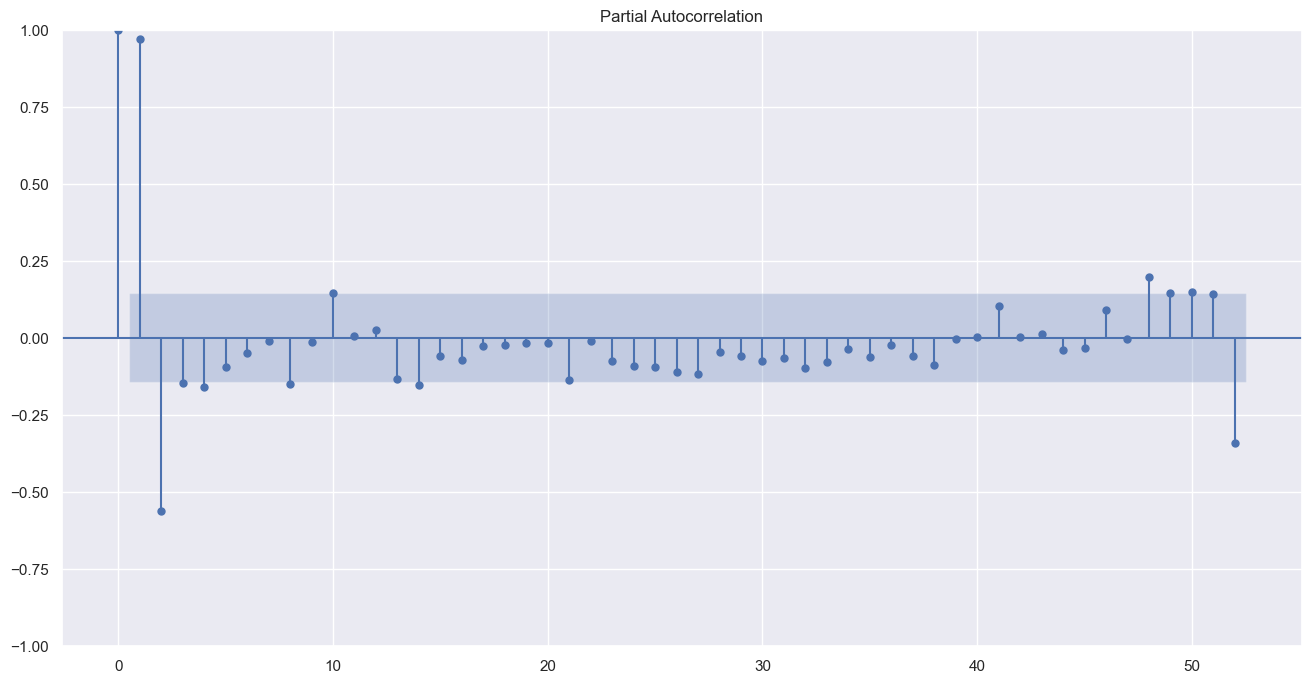

In [11]:
# plot pacf and specify the number of lags - choose p
sm.graphics.tsa.plot_pacf(df, lags=52)
plt.show()

In [12]:
p = 2

# Pre-COVID Data

### Choosing ARIMA Parameters

In [13]:
df_train = pickle.load(open(r"..\data\flu_cases\df_cases_pre_COVID_train.pkl", "rb" ))
df_test = pickle.load(open(r"..\data\flu_cases\df_cases_pre_COVID_test.pkl", "rb" ))

df_train = df_train.set_index('Week Ending')
df_test = df_test.set_index('Week Ending')

In [14]:
df = pd.concat([df_train, df_test], axis=0)
df

,Total Cases
Week Ending,
2016-09-03,2.0
2016-09-10,18.0
2016-09-17,23.0
2016-09-24,44.0
2016-10-01,63.0
...,...
2020-02-01,4789.0
2020-02-08,4654.0
2020-02-15,3989.0


In [15]:
# test for stationarity - choose d
test_stationarity(df)

Results of Dickey-Fuller Test:
Test Statistic                  -4.279900
p-value                          0.000481
#Lags Used                       5.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64


In [16]:
d = 0 # time series is stationary, so don't need to apply differencing

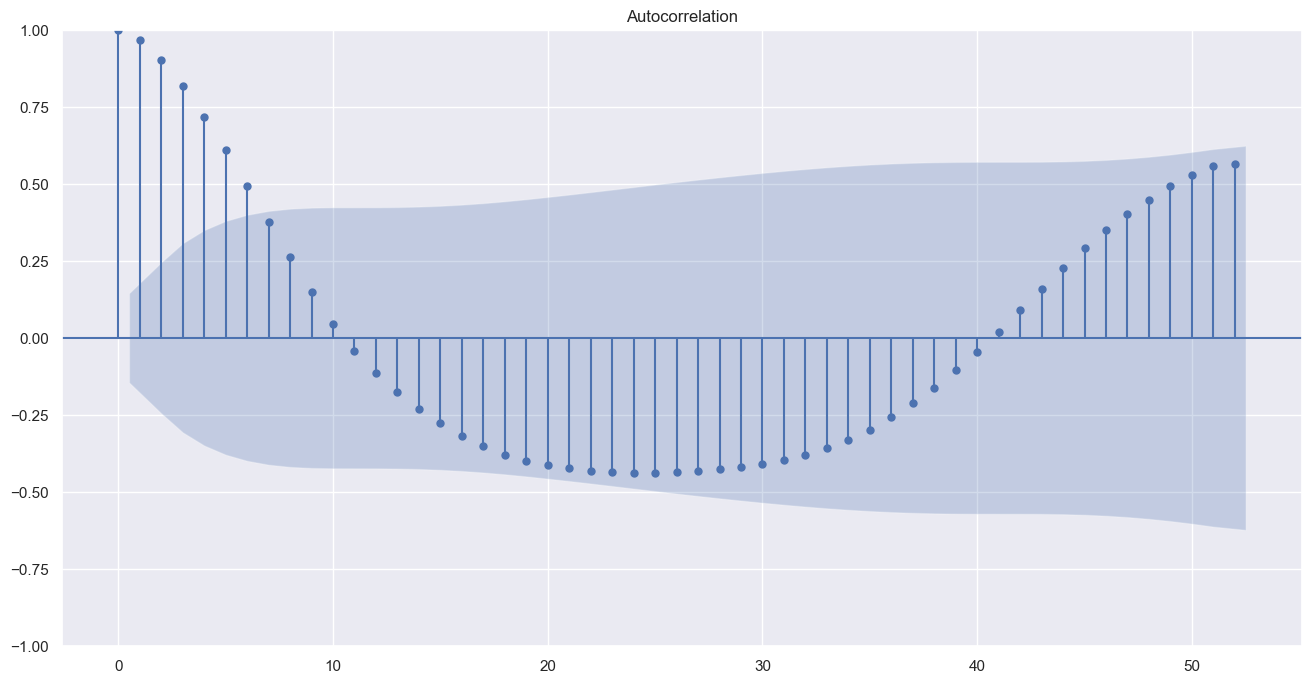

In [17]:
# plot acf and specify the number of lags - choose q
sm.graphics.tsa.plot_acf(df, lags=52)
plt.show()

In [18]:
q = 6

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


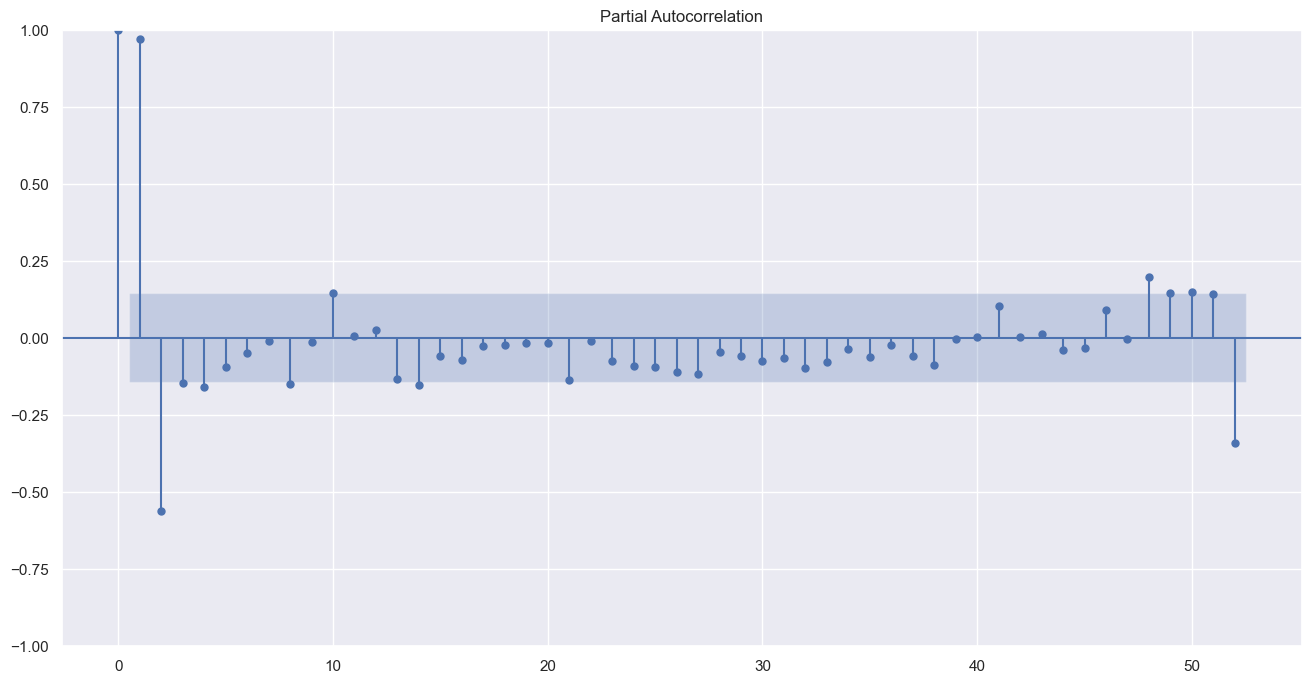

In [19]:
# plot pacf and specify the number of lags - choose p
sm.graphics.tsa.plot_pacf(df, lags=52)
plt.show()

In [20]:
p = 2

Fitted model summary: 
                               SARIMAX Results                                
Dep. Variable:            Total Cases   No. Observations:                  128
Model:                 ARIMA(2, 0, 6)   Log Likelihood                -873.227
Date:                Fri, 02 Dec 2022   AIC                           1766.453
Time:                        20:20:27   BIC                           1794.973
Sample:                    09-03-2016   HQIC                          1778.041
                         - 02-09-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1040.7534    712.694      1.460      0.144    -356.101    2437.608
ar.L1          1.7565      0.224      7.834      0.000       1.317       2.196
ar.L2         -0.8115      0.

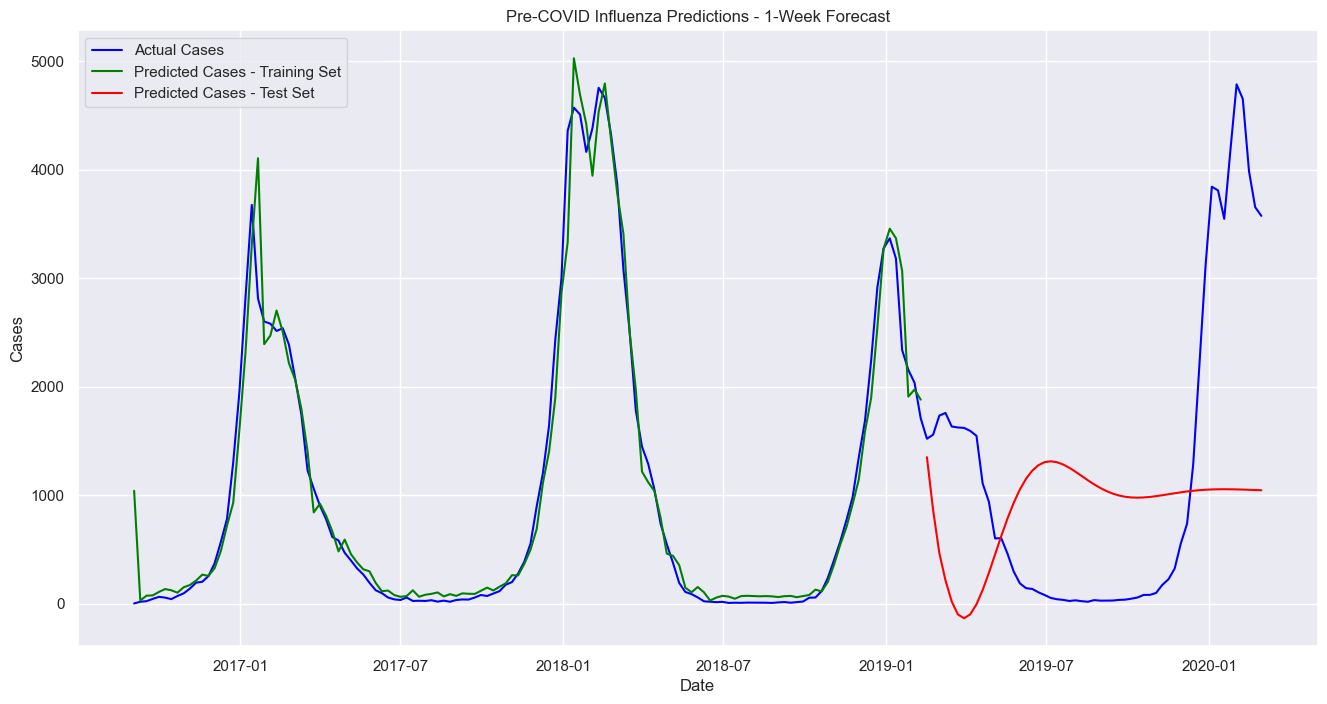

In [21]:
# 1, 2, 3, and 4 week predictions on training set

results_matrix = arima_model(train=df_train, test=df_test, dataset='Pre-COVID', forecast_weeks=1, p = 2, d = 0, q = 6)

In [22]:
results_matrix

,Dataset,Weeks-ahead Forecast,MSE_train,MSE_test,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
0,Pre-COVID,1,55782.45,2446350.98,236.18,1564.08,132.01,1314.4,0.969277,-0.178145


# Full Dataset

### Choosing ARIMA Parameters

In [23]:
df_train = pickle.load(open(r"..\data\flu_cases\df_cases_train.pkl", "rb" ))
df_test = pickle.load(open(r"..\data\flu_cases\df_cases_test.pkl", "rb" ))

df_train = df_train.set_index('Week Ending')
df_test = df_test.set_index('Week Ending')

In [24]:
df = pd.concat([df_train, df_test], axis=0)
df

,Total Cases
Week Ending,
2015-09-05,9.0
2015-09-12,18.0
2015-09-19,15.0
2015-09-26,29.0
2015-10-03,59.0
...,...
2022-10-22,438.0
2022-10-29,1031.0
2022-11-05,2407.0


In [25]:
# test for stationarity - choose d
test_stationarity(df)

Results of Dickey-Fuller Test:
Test Statistic                  -4.307642
p-value                          0.000431
#Lags Used                       6.000000
Number of Observations Used    370.000000
Critical Value (1%)             -3.448148
Critical Value (5%)             -2.869383
Critical Value (10%)            -2.570948
dtype: float64


In [26]:
d = 0 # time series is stationary, so don't need to apply differencing

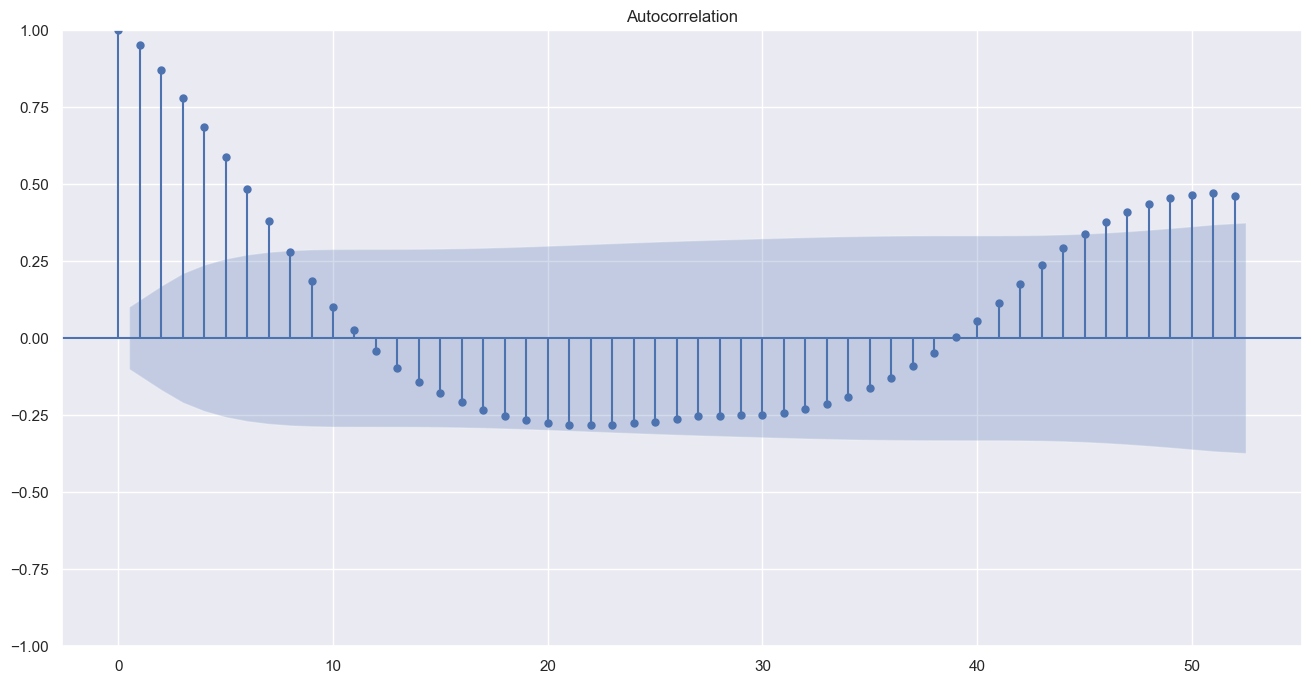

In [27]:
# plot acf and specify the number of lags - choose q
sm.graphics.tsa.plot_acf(df, lags=52)
plt.show()

In [28]:
q = 6

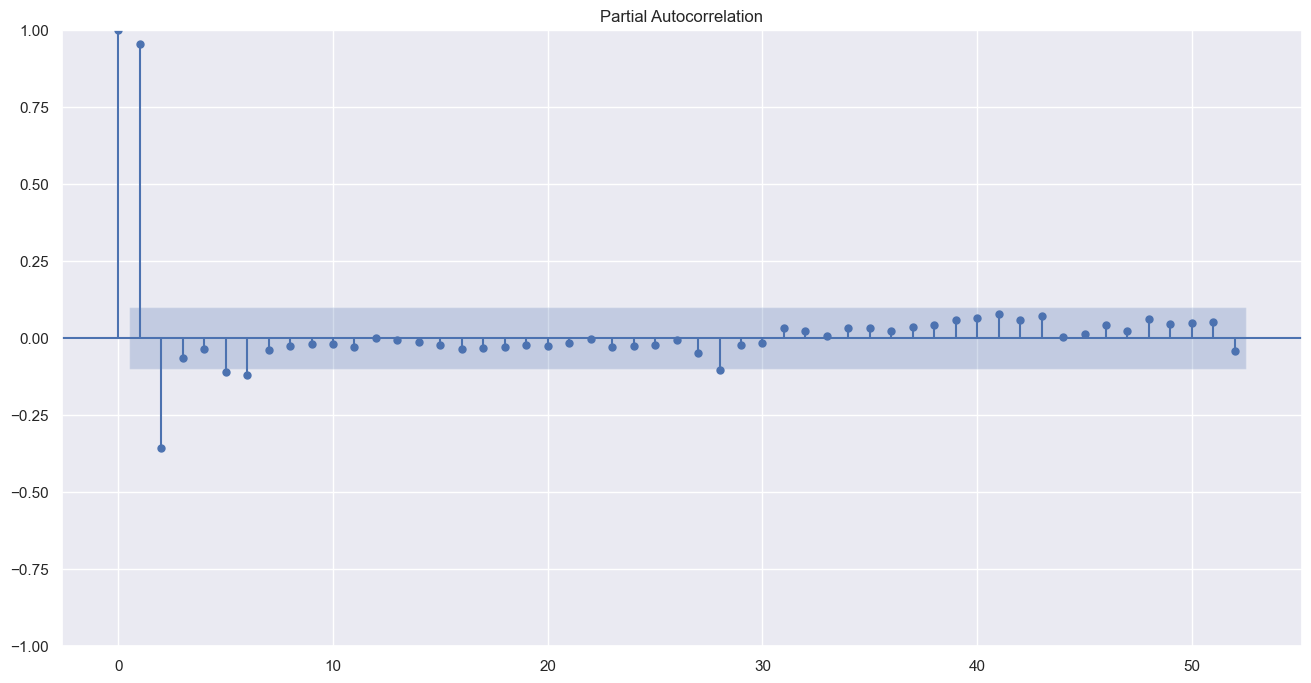

In [29]:
# plot pacf and specify the number of lags - choose p
sm.graphics.tsa.plot_pacf(df, lags=52)
plt.show()

In [30]:
p = 2

Fitted model summary: 
                               SARIMAX Results                                
Dep. Variable:            Total Cases   No. Observations:                  301
Model:                 ARIMA(2, 0, 6)   Log Likelihood               -2028.134
Date:                Fri, 02 Dec 2022   AIC                           4076.269
Time:                        20:20:29   BIC                           4113.340
Sample:                    09-05-2015   HQIC                          4091.103
                         - 06-05-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        818.1323    513.849      1.592      0.111    -188.993    1825.257
ar.L1          1.7295      0.154     11.255      0.000       1.428       2.031
ar.L2         -0.7777      0.

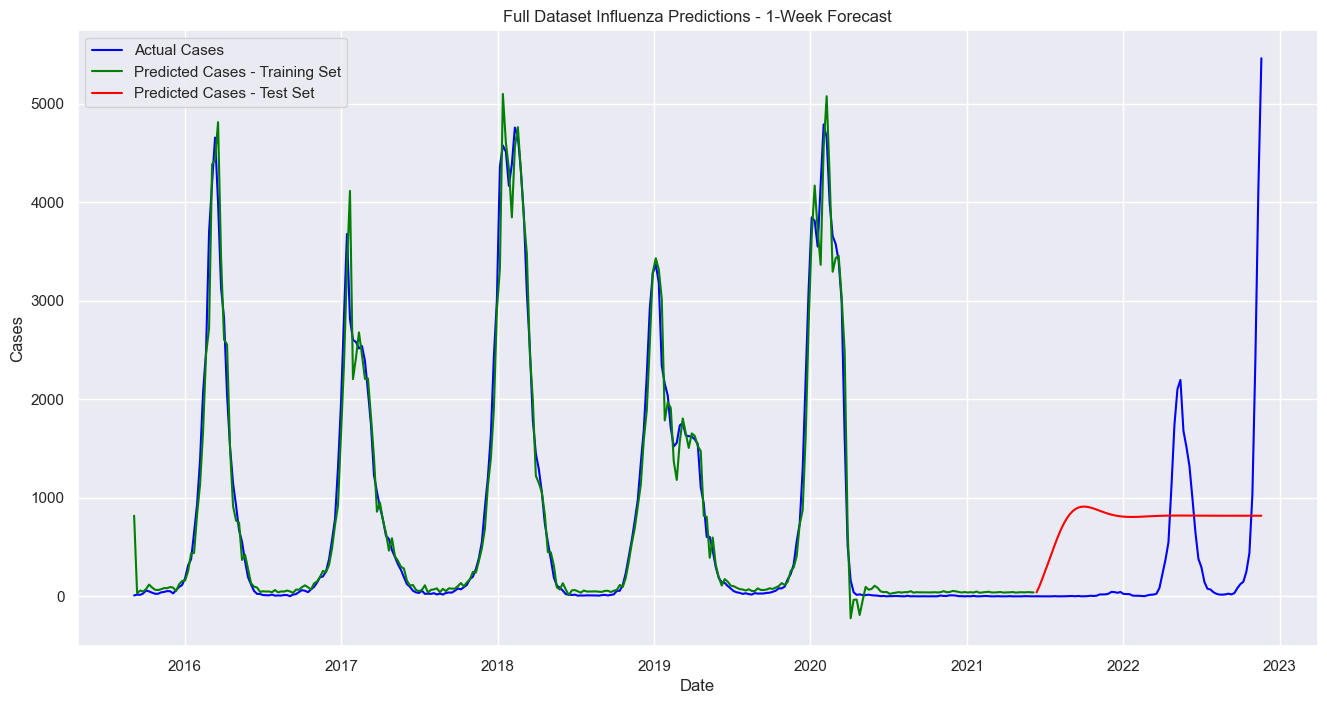

In [31]:
# 1, 2, 3, and 4 week predictions on training set

results_matrix = arima_model(train=df_train, test=df_test, dataset='Full Dataset', forecast_weeks=1, p = 2, d = 0, q = 6)

In [32]:
results_matrix

,Dataset,Weeks-ahead Forecast,MSE_train,MSE_test,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
0,Pre-COVID,1,55782.45,2446350.98,236.18,1564.08,132.01,1314.4,0.969277,-0.178145
0,Full Dataset,1,43189.87,981495.62,207.82,990.7,113.41,790.79,0.973664,-0.153661
